In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import datetime
import matplotlib
from matplotlib import pyplot

In [2]:
#from fastai.imports import *
#from fastai.structured import *

SyntaxError: invalid syntax (structured.py, line 33)

In [3]:
prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/V1.1FeaturesWithLabelsTestRegion220131201To20180430.csv', parse_dates=['Date'], low_memory=False)
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "UnifiedRegion", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    
if(normalize):
    #normalize data; not necessary for xgboost
    scaler = Normalizer()
    dontNormalize = input_categorical_columns + output_columns + prediction_trend_data + metadata_columns
    df.loc[:, ~df.columns.isin(dontNormalize)] = scaler.fit_transform(df.loc[:, ~df.columns.isin(dontNormalize)])

In [4]:
df = df[df['o_Day1DangerAboveTreeline']!='no-data']
df = df[df['o_Day1DangerNearTreeline']!='no-data']
df = df[df['o_Day1DangerBelowTreeline']!='no-data']


df = df[df['o_Day1DangerAboveTreeline']!='Extreme']
df = df[df['o_Day1DangerNearTreeline']!='Extreme']
df = df[df['o_Day1DangerBelowTreeline']!='Extreme']

In [5]:
df['DayOfYear'] = df['Date'].dt.dayofyear

In [7]:
splitBySeason = True
testAsMostRecent = False
yColumns = ['o_Day1DangerAboveTreeline']
yNearColumn = ['o_Day1DangerNearTreeline']
yBelowColumn = ['o_Day1DangerBelowTreeline']

if(splitBySeason):
    if(testAsMostRecent):
        df_train = df[df['Date'] < datetime.datetime(2017, 5, 1)] 
        df_test = df[df['Date'] > datetime.datetime(2017, 5, 1)]
    else:
        df_train = df[(df['Date'] < datetime.datetime(2016, 5, 1)) | (df['Date'] > datetime.datetime(2017, 5, 1))] 
        df_test = df[(df['Date'] > datetime.datetime(2016, 5, 1)) & (df['Date'] < datetime.datetime(2017, 5, 1))]
    
    y_Above_train = df_train[yColumns + metadata_columns]
    y_Near_train = df_train[yNearColumn + metadata_columns]
    y_Below_train = df_train[yBelowColumn + metadata_columns]
    
    y_Above_test = df_test[yColumns + metadata_columns]
    y_Near_test = df_test[yNearColumn + metadata_columns]
    y_Below_test = df_test[yBelowColumn + metadata_columns]
    
    #feature engineer date
    #add_datepart(df_train, 'Date')
    #add_datepart(df_test, 'Date')
    date_columns = ['DayOfYear']
    
    #same x input trained to get a different output
    X_Above_train = X_Near_train = X_Below_train = df_train[input_numeric_columns+input_categorical_columns+date_columns]
    X_Above_test = X_Near_test = X_Below_test = df_test[input_numeric_columns+input_categorical_columns+date_columns]
    
   
    
else:
    #random stratified split
    X = df[input_numeric_columns+input_categorical_columns]
    
    yAbove=df[yColumns + metadata_columns]
    X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_Day1DangerAboveTreeline"], test_size=0.20, random_state=1)
    
    yNear=df[yNearColumn+metadata_columns]
    X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_Day1DangerNearTreeline'], test_size=0.20, random_state=1)
    
    yBelow=df[yBelowColumn+metadata_columns]
    X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_Day1DangerBelowTreeline'], test_size=0.20, random_state=1)

In [10]:
X_Above_train.tail()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev7DayWindSlabLikeliness8InPast,c_r_Prev3DayFreezeThawLikeliness9InPast,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast,DayOfYear
134242,0.250,3.498339,0.250,2.991883,0.375,3.180753,0.625,2.986401,0.875,2.337439,...,0,1,1,0,0,1,1,0,0,347
134243,0.500,3.412153,0.750,2.453915,1.375,2.238766,2.000,1.594356,2.625,1.469435,...,0,1,1,0,0,1,1,0,0,347
134244,0.125,3.844089,0.125,3.638352,0.375,3.879538,0.500,3.780000,0.750,2.853918,...,0,1,1,0,0,1,1,0,0,347
134245,0.500,3.654338,0.750,2.830525,1.250,2.489981,1.625,1.786699,2.250,1.566147,...,0,1,1,0,0,1,1,0,0,347
134246,0.250,3.458072,0.375,2.713073,0.750,2.500116,1.125,1.872651,1.500,1.674750,...,0,1,1,0,0,1,1,0,0,347


In [11]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

Moderate        36016
Considerable    27156
Low             23843
High             6084
Name: o_Day1DangerAboveTreeline, dtype: int64

In [18]:

#parameters derived from a several step parameter search
grid = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7}
#modelAbove = XGBClassifier(tree_method='gpu_hist', n_jobs=10)
modelAbove = XGBClassifier(n_jobs=10)
modelAbove.set_params(**grid)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [ ]:
modelNear = XGBClassifier(n_jobs=10)
modelNear.set_params(**grid)

modelBelow = XGBClassifier(n_jobs=10)
modelBelow.set_params(**grid)

In [19]:
%%time
val = modelAbove.fit(X_Above_train, y_Above_train[yColumns].values.ravel())


Wall time: 6min 8s


In [6]:
#grid = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7, 'tree_method':'gpu_hist'}

#modelAboveGPU = XGBClassifier(n_jobs=10)
#modelAboveGPU.set_params(**grid)

ValueError: Invalid parameter tree_method for estimator XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
mapping = {'Low': 0, 'Moderate': 1, 'Considerable': 2, 'High': 3, 'Extreme': 4}
df = y_Above_train.replace({'o_Day1DangerAboveTreeline': mapping})

In [ ]:
df['o_Day1DangerAboveTreeline'].values[:10]

In [14]:

import xgboost as xgb
param = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7, 'tree_method':'gpu_hist', 'num_class' : 5}
num_round = 100

dtrain = xgb.DMatrix(X_Above_train, df['o_Day1DangerAboveTreeline'].values)


ValueError: could not convert string to float: 'Considerable'

In [ ]:
%%time
model = xgb.train(param, dtrain, num_round)

In [ ]:
paramcpu = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7, 'n_jobs': 10, 'num_class' : 5}
num_round = 100

dtraincpu = xgb.DMatrix(X_Above_train, df['o_Day1DangerAboveTreeline'].values)

In [ ]:
%%time
modelcpu = xgb.train(paramcpu, dtraincpu, num_round)

In [ ]:
modelAboveGPU.get_params().keys()

In [ ]:
%%time
val = modelAboveGPU.fit(X_Above_train, y_Above_train[yColumns].values.ravel())

In [ ]:
valnear = modelNear.fit(X_Near_train, y_Near_train[yNearColumn].values.ravel())
valbelow = modelBelow.fit(X_Below_train, y_Below_train[yBelowColumn].values.ravel())

In [20]:
resultAbove = modelAbove.predict(X_Above_test)
#resultNear = modelNear.predict(X_Near_test)
#resultBelow = modelBelow.predict(X_Below_test)

C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.5636343422552045
Classification Report
              precision    recall  f1-score   support

Considerable       0.46      0.59      0.52     12692
        High       0.35      0.08      0.13      4056
         Low       0.92      0.73      0.81      6383
    Moderate       0.57      0.61      0.59     12848

 avg / total       0.57      0.56      0.55     35979

Normalized confusion matrix
Confusion matrix, without normalization


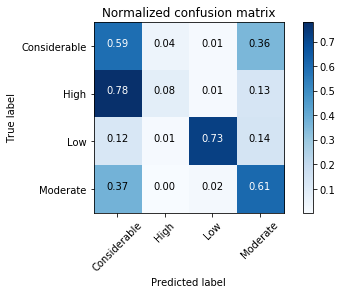

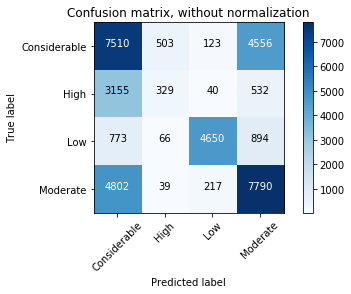

In [22]:
evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], resultAbove)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], resultAbove)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], resultNear)

cnf_matrix = confusion_matrix(y_Near_test['o_Day1DangerNearTreeline'], resultNear)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
evaluateSingleClassShort(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
cnf_matrix = confusion_matrix(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
#check out the feature importances
featureImportance = dict(zip(X_Above_train.columns, modelAbove.feature_importances_))
sortedFeatureImportance = sorted(featureImportance, key=featureImportance.get, reverse=True)

In [ ]:
sortedFeatureImportance[:100]

In [ ]:
#save the models
modelAbove._Booster.save_model("ModelAboveV1.bin")
modelNear._Booster.save_model("ModelNearV1.bin")
modelBelow._Booster.save_model("ModelBelowV1.bin")

In [ ]:
%%time #3 mins
# grid search
model = XGBClassifier(tree_method='gpu_hist')
learning_rate = [0.01]
n_estimators = [100, 200]
#max_depth = range(3,10,2)
#min_child_weight = range(1,6,2)
#gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, objective=["gpu:multi:softmax"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=8, cv=kfold)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time #1 hour 30 mins
# grid search
model = XGBClassifier()
learning_rate = [0.01]
n_estimators = [100, 200]
#max_depth = range(3,10,2)
#min_child_weight = range(1,6,2)
#gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, objective=["multi:softmax"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=8, cv=kfold)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time
# grid search
model = XGBClassifier(tree_method='gpu_hist')
learning_rate = [0.01, .1]
n_estimators = [400, 700]
#max_depth = range(3,10,2)
#min_child_weight = range(1,6,2)
#gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, objective=["gpu:multi:softmax"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", cv=kfold, verbose=20)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] objective=gpu:multi:softmax, learning_rate=0.01, n_estimators=400 
[CV]  objective=gpu:multi:softmax, learning_rate=0.01, n_estimators=400, score=-0.7615631388412664, total=  33.3s
[CV] objective=gpu:multi:softmax, learning_rate=0.01, n_estimators=400 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.9s remaining:    0.0s
